#### 해당 코드는 '딥러닝 파이토치 교과서(길벗, 2022)' 교재를 공부하며 작성한 코드입니다.
#### 이미지 출처 - https://thebook.io/

# 4.1 이미지 분류를 위한 신경망
## 4.1.1 LeNet-5
- 합성곱(convolutional)과 다운샘플링(downsampling, 풀링)을 반복적으로 거치면서마지막에 완전 연결층에서 분류를 수행

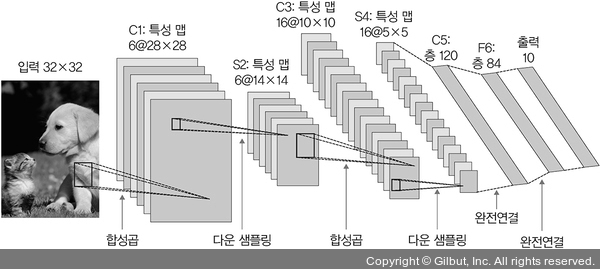

- C는 합성곱층, S는 풀링층, F는 완전연결층
    - C1 : 5x5 합성곱 연산 후 28x28 크기의 특성 맵 6개를 생성
    - S2 : 다운샘플링을 통해 특성 맵 크기를 14x14로 줄임
    - C3 : 5x5 합성곱 연산 후 10x10 크기의 특성 맵 16개 생성
    - S4 : 다운샘플링하여 특성 맵 크기 5x5
    - C5 : 5x5 합성곱 연산 후 1x1 크기의 특성 맵 120개를 생성
    - F6 : 완전연결층으로 C5의 결과를 유닛(노드) 84개에 연결
    
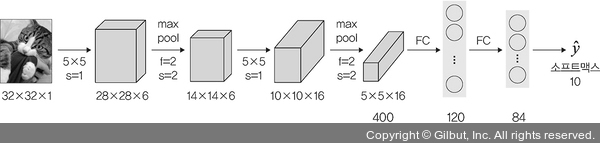
- 32x32 크기의 이미지에 합성곱층과 최대 풀링층이 쌍으로 두 번 적용된 후 완전연결층을 거쳐 이미지가 분류되는 신경망
- LeNet-5 예제 신경망 상세
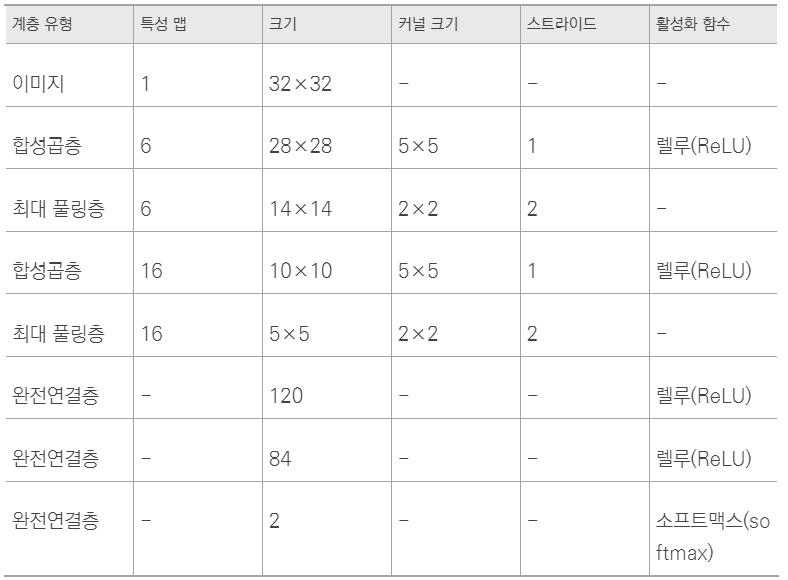

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 이미지 데이터셋 전처리
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

- 토치비전(torchvision) 라이브러리를 통해 이미지 전처리 수행
- transforms.Compose : 이미지를 변형할 수 있는 방식들의 묶음
- transforms.RandomResizedCrop : 입력 이미지를 주어진 크기(resize : 224x224)로 조정
    - scale : 원래 이미지를 임의의 크기(0.5 ~ 1.0(50%~100%))만큼 면적을 무작위로 자름
- transforms.RandomHorizontalFlip : 주어진 호가률로 이미지를 수평 반전(default : 0.5)
    - 훈련 이미지 중 반은 위아래 뒤집힌 상태로 두고, 반은 그대로 사용
- transforms.ToTensor : PIL로 이미지를 읽으면 이미지 범위가 [0,255], 배열의 차원은 (H x W x C) -> 효율적인 연산을 위해 torch.FloatTensor 배열로 변경
    - 픽셀 값의 범위는 [0.0, 1.0], 차원의 순서도 (C x H x W)로 변경
- transforms.Normalize : 사전 훈련된 모델을 사용하기 위해 ImageNet 데이터의 각 채널별 평균과 표준편차에 맞는 정규화를 수행
    - OpenCV를 사용해서 이미지를 읽어오면 RGB 이미지가 아닌 BGR 이미지
- call : 클래스를 호출 -> 클래스 객체 자체를 호출하면 call 함수의 리턴 값이 반환

In [3]:
# 이미지 데이터셋을 불러아 훈련, 검증, 테스트 데이터로 분리
cat_directory = r'./data/dogs-vs-cats/Cat/'
dog_directory = r'./data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] # 개와 고양이 이미지를 합쳐서 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:400] # 훈련용 이미지 400개
val_images_filepaths = correct_images_filepaths[400:-10] # 검증용 이미지 92개
test_images_filepaths = correct_images_filepaths[-10:] # 테스트용 이미지 10개
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [4]:
# 테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

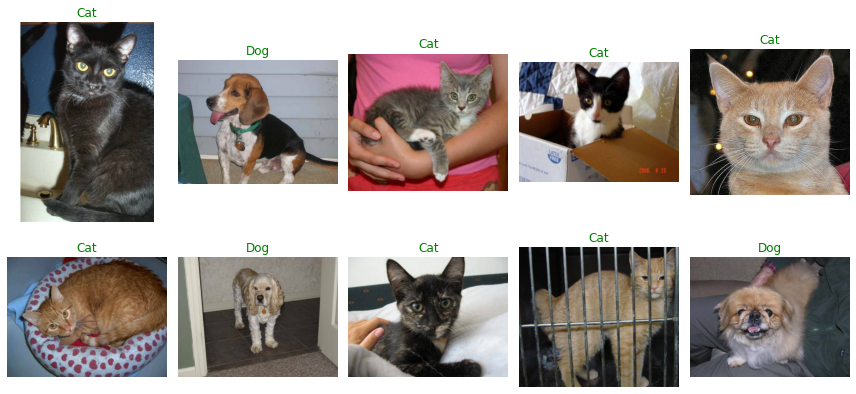

In [5]:
display_image_grid(test_images_filepaths)

In [6]:
# 이미지 데이터셋클래스 정의 
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

- 데이터셋 크기가 클 수 있으므로 init에서 전체 데이터를 읽어오는 것이 아니라 경로만 저장
- getitem 메서드에서 이미지를 읽어옴 -> 데이터를 어디에서 가져올지 결정
- 고양이의 레이블은 0, 개의 레이블은 1로 구현

In [7]:
# 전처리에서 사용할 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [8]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train') # train transform
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val') # test transform

index = 0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터의 크기
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 레이블

torch.Size([3, 224, 224])
0


In [9]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1])


- 한 번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에 파이토치의 데이터로더를 통해 데이터를 그룹으로 쪼개서 조금씩 불러옴

In [10]:
# LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = out.view(out.size(0), -1) # fully connected 층에 전달하기 위해 1차원으로 데이터 변형
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [11]:
from torchsummary import summary

# 모델 객체 생성
model = LeNet()
summary(model.cuda(), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [12]:
# 옵티마이저와 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

- 손실 함수의 reduction 파라미터의 기본값은 mean
    - mean : 정답과 예측 간의 오차를 구한 후 그 값들의 평균을 반환
- 손실 함수 특성상 전체 오차를 배치 크기로나눔으로써 평균을 반환하기 때문에 epoch_loss를 계산하는 동안에는 loss.item()과 inputs.size(0)을 곱해야함

In [13]:
# 모델의 파라미터와 손실 함수를 GPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [14]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:           
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # 역전파 단계를 수행하기 위해 기울기를 0으로 초기화
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기 계산
                        optimizer.step() # 파라미터 갱신
                        
                    epoch_loss += loss.item() * inputs.size(0) # 위 마크다운 참고
                    epoch_corrects += torch.sum(preds == labels.data) # 정답과 예측이 일치하면 epoch_corrects에 저장
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [15]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\tactics\AppData\Local\Temp/ipykernel_14732/1976792366.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6976 Acc: 0.4725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7118 Acc: 0.4022
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7005 Acc: 0.4775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7079 Acc: 0.4783
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6797 Acc: 0.5850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7116 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6808 Acc: 0.5750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7178 Acc: 0.4783
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6743 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7185 Acc: 0.5000
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6777 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7125 Acc: 0.5000
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6887 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6989 Acc: 0.5000
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6829 Acc: 0.5450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6956 Acc: 0.5543
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6709 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6988 Acc: 0.5326
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6607 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6937 Acc: 0.5543
Training complete in 0m 16s
Best val Acc: 0.554348


In [17]:
# 모델 테스트를 위한 함수 정의
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0) # 텐서에 차원을 추가
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('./data/LeNet.csv', index=False)

C:\Users\tactics\AppData\Local\Temp/ipykernel_14732/3058817054.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

- torch.no_grad() : 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타냄 -> 훈련 데이터셋의 모델 학습과의 차이점
- softmax : 지정된 차원을 따라 텐서의 요소가 (0,1) 범위에 있고 합계가 1이 되도록 크기를 다시 조정

In [18]:
res.head(10)

,id,label
0,145,0.392647
1,211,0.547084
2,162,0.499284
3,200,0.470850
4,210,0.585244
5,224,0.539978
6,213,0.439443
7,109,0.519322
8,15,0.523063
9,167,0.500811


- 예측 결과 label이 0.5보다 크면 개를 의미하고, 0.5보다 작으면 고양이를 의미

In [19]:
# 테스트 데이터셋 이미지 출력
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

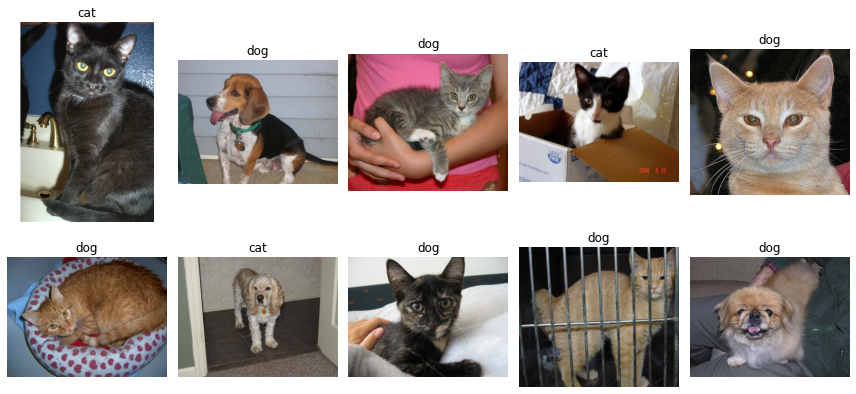

In [20]:
display_image_grid(test_images_filepaths) 

- 극히 일부의 데이터를 이용한 모델 학습을 진행했기 때문에 예측력이 좋지 않음